In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Get data

In [ ]:
# Numpy objects

import numpy as np

all_palms_np = np.load('palm_data.npy')   # (15, 480, 640, 3)
all_punchs_np = np.load('punch_data.npy')   # (2, 480, 640, 3)

palms_zoom_1_np = np.load('palm_data_zoom_1.npy')
punchs_zoom_1_np = np.load('punch_data_zoom_1.npy')


In [ ]:
# img objects
import os
import PIL
import PIL.Image
import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" #
#dataset_url = "file:///content/gestures-photos.tar.gz"
#archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)


#!tar xvf "/content/gestures-photos.tar.gz"   # Uncomment when a new tar is uploaded

data_dir = pathlib.Path("/content/gestures-photos").with_suffix('')



palms = list(data_dir.glob('palm/*.jpg'))
punchs = list(data_dir.glob('punch/*.jpg'))

all_palms = []
for count, palm in enumerate(palms):
  image_file = tf.keras.utils.get_file(f"palm_{count}.jpg", f"file://{palm}")  # CAUTION, file is cached by name
  img = tf.keras.preprocessing.image.load_img(image_file)

  image_array = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)   # defaults to float [0.0, 255.0]
  all_palms.append(image_array)


all_punchs = []
for count, punch in enumerate(punchs):
  image_file = tf.keras.utils.get_file(f"punch_{count}.jpg", f"file://{punch}")
  img = tf.keras.preprocessing.image.load_img(image_file)

  image_array = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
  all_punchs.append(image_array)



34547/34547 [==============================] - 0s 0us/step


In [ ]:
# concatenate img and numpy objects

all_palms = np.array(all_palms)


# images must be of the same shape in order to this to work.
# This means resizing needs to happen first, or use all images of same size.
palm_ds = np.concatenate([all_palms_np, all_palms, palms_zoom_1_np], axis=0)
punch_ds = np.concatenate([all_punchs_np, all_punchs, punchs_zoom_1_np], axis=0)


# clean up
punch_deletes = (3, 6, 15, 22, 32, 33, 34, 43, 50 )
punch_ds = np.delete(punch_ds, punch_deletes, 0)
#np.save(f'punch_v1_data', punch_ds)


palm_deletes = (10, 11, 16, 17, 33, 34, 36, 37, 41, 42, 52, 53, 56, 57, 58)
palm_ds = np.delete(palm_ds, palm_deletes, 0)
#np.save(f'palm_v1_data', palm_ds)



#Show data

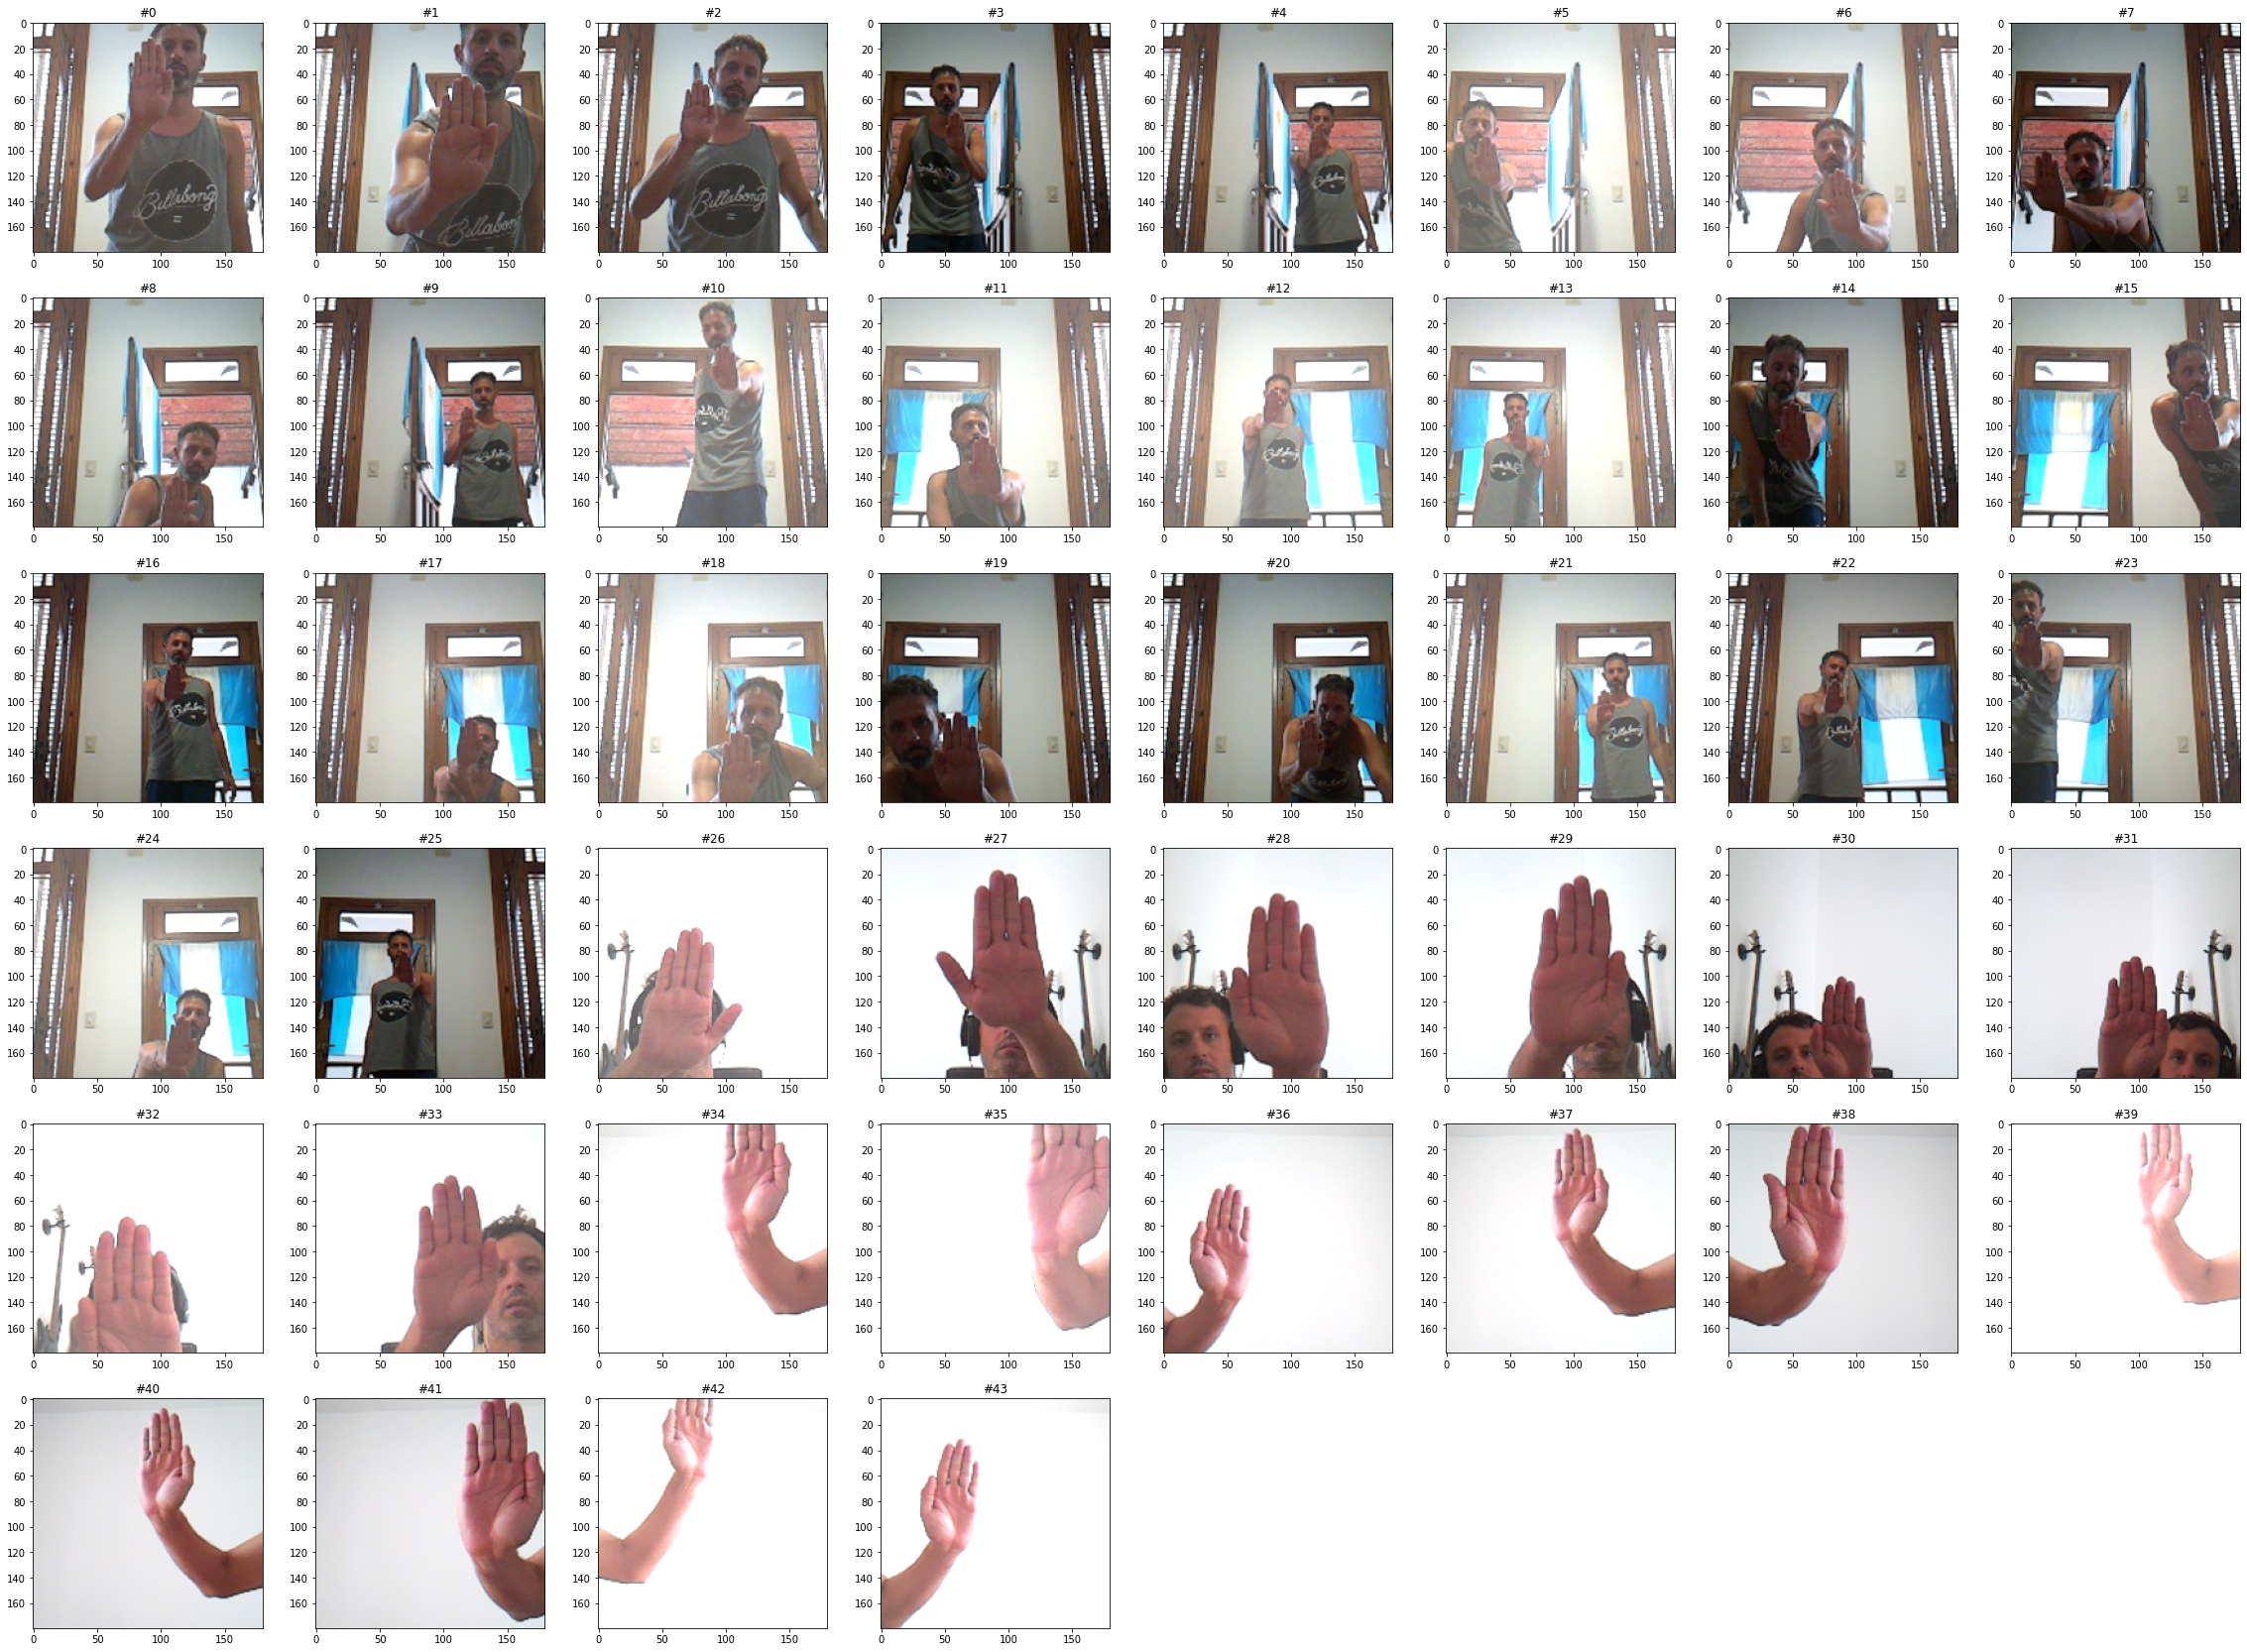

In [ ]:
from matplotlib import pyplot

# If The plot is not looking good. The reason is that if the color intensity is a float, then matplotlib expects it to range from 0 to 1. If an int, then it expects 0 to 255.


def plot_ds(data_set):
  num_of_images = data_set.shape[0]

  pyplot.figure(figsize=(40, 40))
  for j in range(num_of_images):
      image_data = data_set[j]
      ax = pyplot.subplot(8, 8, j + 1)
      augmented_image = data_augmentation(image_data)
      pyplot.imshow(np.array(augmented_image,np.uint8))
      #pyplot.imshow(augmented_image)
      pyplot.title(f"#{j}")
      #pyplot.axis("off")

  pyplot.show()


def plot_image(image):
  pyplot.subplot()
  pyplot.imshow(image, cmap=pyplot.get_cmap('gray'))
  pyplot.show()

def plot_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    pyplot.figure(figsize=(8, 8))
    pyplot.subplot(1, 2, 1)
    pyplot.plot(epochs_range, acc, label='Training Accuracy')
    pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
    pyplot.legend(loc='lower right')
    pyplot.title('Training and Validation Accuracy')

    pyplot.subplot(1, 2, 2)
    pyplot.plot(epochs_range, loss, label='Training Loss')
    pyplot.plot(epochs_range, val_loss, label='Validation Loss')
    pyplot.legend(loc='upper right')
    pyplot.title('Training and Validation Loss')
    pyplot.show()




IMG_SIZE = 180
IMG_SIZE_CROP = 280

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.CenterCrop(IMG_SIZE_CROP, IMG_SIZE_CROP),
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  #tf.keras.layers.Rescaling(1./255),
  #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  #tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomZoom(0.1),
  
  tf.keras.layers.RandomBrightness(factor=(0.0, 0.4)),
  tf.keras.layers.RandomFlip(mode="horizontal")
])


plot_ds(palm_ds)







In [ ]:
# Adding augmentation by applying it to the dataset


# Add the image to a batch.
#image = tf.cast(tf.expand_dims(image, 0), tf.float32)   # new shape (1, 180, 180, 3)


def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label


def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  #image = tf.image.central_crop(image, central_fraction=0.5)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(image, max_delta=0.95, seed=new_seed)
  #image = tf.image.stateless_random_contrast(image, lower=0.1, upper=0.9, seed=seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label



#plot_image(palm_ds[0])

#image = augment((palm_ds[0], 1), (1, 0))
#pyplot.subplot()
#pyplot.imshow(image[0])
#pyplot.show()



# Prepare and normilize data

In [ ]:
import tensorflow as tf

class_names = ("palm", "punch")  # hand gestures
num_classes = len(class_names)

img_height = 180
img_width = 180

BATCH_SIZE = 15
SHUFFLE_BUFFER_SIZE = 100

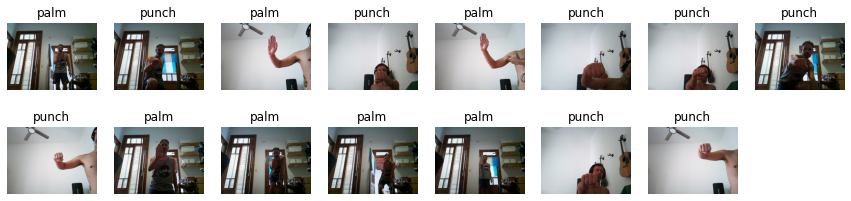

In [ ]:
# This is for data in numpy format
np.random.shuffle(palm_ds)
np.random.shuffle(punch_ds)

# Split Palm and Punch datasets to get train and validation datasets
train_split_index = int(0.8 * palm_ds.shape[0])   # index of the ~80%
train_palms, val_palms = np.split(palm_ds, [train_split_index])

train_split_index = int(0.8 * punch_ds.shape[0])
train_punchs, val_punchs = np.split(punch_ds, [train_split_index])

train_examples = np.concatenate([train_palms, train_punchs], axis=0)
validate_examples = np.concatenate([val_palms, val_punchs], axis=0)

# class vector - palm = 0 , punch = 1
palm_ds_labels = np.zeros(train_palms.shape[0], dtype=int)
punch_ds_labels = np.ones(train_punchs.shape[0], dtype=int)
train_labels = np.concatenate([palm_ds_labels, punch_ds_labels], axis=0)

palm_ds_val_labels = np.zeros(val_palms.shape[0], dtype=int)
punch_ds_val_labels = np.ones(val_punchs.shape[0], dtype=int)
val_labels = np.concatenate([palm_ds_val_labels, punch_ds_val_labels], axis=0)

# final datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((validate_examples, val_labels))




"""
Shuffle: The goal of this one is to take the next X images, where X is the buffer size, and mix them every time we pass over the dataset, This ensures that the data is shuffled differently at every epoch of the training
"""
#train_ds_from_array = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#val_ds_from_array = val_ds.batch(BATCH_SIZE)
AUTOTUNE = tf.data.AUTOTUNE
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


image_batch, label_batch = next(iter(train_ds))

pyplot.figure(figsize=(15, 15))
for i in range(15):
  ax = pyplot.subplot(8, 8, i + 1)
  pyplot.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  pyplot.title(class_names[label])
  pyplot.axis("off")





In [ ]:
# this is for data in images format (dir path)
# it's already returning datasets (data, label) in batch. Couldn't find a way to concatenate with other sources, so not going this way.

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  #image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  #image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)


#train_ds = train_ds.concatenate(train_ds_from_array)
#val_ds = val_ds.concatenate(val_ds_from_array)


#for image_batch, labels_batch in train_ds:
#  print(image_batch)
#  print(labels_batch)
#  break


Found 42 files belonging to 2 classes.
Using 34 files for training.
Found 42 files belonging to 2 classes.
Using 8 files for validation.
tf.Tensor(
[[[[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.89019531e+02 1.84019531e+02 1.90019531e+02]
   [1.84708221e+02 1.79708221e+02 1.85708221e+02]
   [1.78908173e+02 1.73410126e+02 1.77417938e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.89330170e+02 1.84330170e+02 1.90330170e+02]
   [1.82305969e+02 1.77305969e+02 1.83305969e+02]
   [1.77280823e+02 1.71782776e+02 1.75790588e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.90544922e+02 1.85544922e+02 1.91544922e+02]
   [1.81066406e+02 1.760664

In [ ]:
print(train_examples.shape)


for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break



(48, 480, 640, 3)
(15, 480, 640, 3)
(15,)


# The model

In [ ]:
from tensorflow.keras import layers


IMG_SIZE = 180
IMG_SIZE_CROP = 280

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.CenterCrop(IMG_SIZE_CROP, IMG_SIZE_CROP),
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.RandomBrightness(factor=(0.0, 0.4)),
  tf.keras.layers.RandomFlip(mode="horizontal")
])


model = tf.keras.Sequential([
    #layers.Resizing(img_height, img_width),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


6/6 [==============================] - 9s 569ms/step - loss: 1.0532 - accuracy: 0.4737 - val_loss: 0.6740 - val_accuracy: 0.5500
Epoch 2/15
6/6 [==============================] - 3s 456ms/step - loss: 0.7290 - accuracy: 0.5395 - val_loss: 0.6714 - val_accuracy: 0.5500
Epoch 3/15
6/6 [==============================] - 3s 479ms/step - loss: 0.6935 - accuracy: 0.5395 - val_loss: 0.6734 - val_accuracy: 0.5500
Epoch 4/15
6/6 [==============================] - 4s 703ms/step - loss: 0.6819 - accuracy: 0.5395 - val_loss: 0.6547 - val_accuracy: 0.5500
Epoch 5/15
6/6 [==============================] - 3s 468ms/step - loss: 0.6834 - accuracy: 0.5526 - val_loss: 0.6364 - val_accuracy: 0.7000
Epoch 6/15
6/6 [==============================] - 3s 471ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6437 - val_accuracy: 0.7500
Epoch 7/15
6/6 [==============================] - 4s 737ms/step - loss: 0.6601 - accuracy: 0.5921 - val_loss: 0.6207 - val_accuracy: 0.8500
Epoch 8/15
6/6 [===============

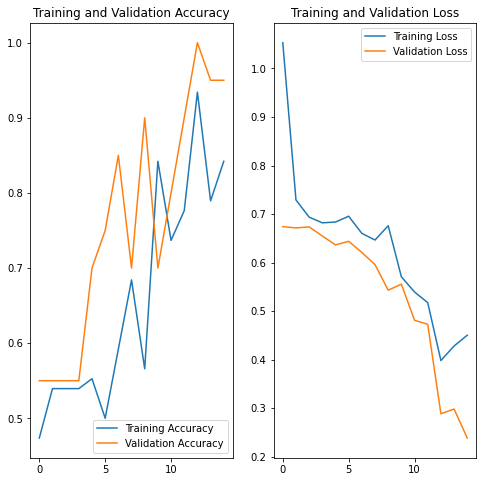

In [ ]:
plot_history(history, epochs)

# Predictions

In [ ]:
#image_url = "file:///content/palm_w_6.jpg"
image_url = "https://dmrqkbkq8el9i.cloudfront.net/Pictures/2000xAny/7/3/7/263737_clem-onojeghuo-108720-unsplash-web.jpg"
image_path = tf.keras.utils.get_file('s1w33sss334445rws', origin=image_url)

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# final datasets
all_palms_to_test = np.load('palm_v1_data.npy')
all_punchs_to_test = np.load('punch_v1_data.npy')
#img_array = tf.expand_dims(all_palms_to_test[6], 0)


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 86ms/step
tf.Tensor([0.5092502 0.4907498], shape=(2,), dtype=float32)
[[1.701399  1.6643939]]
This image most likely belongs to palm with a 50.93 percent confidence.


In [ ]:
model.save('/content/hand-v1/', save_format='tf', save_traces=False)